In [19]:
import torch, cv2, numpy as np, os, time, sys, json, pathlib

from facenet_pytorch import MTCNN, InceptionResnetV1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using", device)


mtcnn  = MTCNN(image_size=160, margin=14, post_process=True, device=device)
embed  = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Using cpu


In [ ]:
refs_path = pathlib.Path("refs")
refs_path.mkdir(exist_ok=True)

ref_db = {}

for jpg in refs_path.glob("*.jpg"):
    name          = jpg.stem
    img_bgr       = cv2.imread(str(jpg))
    img_rgb       = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    face          = mtcnn(img_rgb)
    if face is None:
        raise ValueError(f"No face found in {jpg.name}")
    vec           = embed(face.unsqueeze(0).to(device))[0]
    ref_db[name]  = (vec / vec.norm()).cpu()

np.save("ref_db.npy", ref_db)
print(f"✅  Enrolled {len(ref_db)} users:", ", ".join(ref_db))

✅  Enrolled 4 users: Can, Jeff, Owner, Riccardo


AUC = 1.0


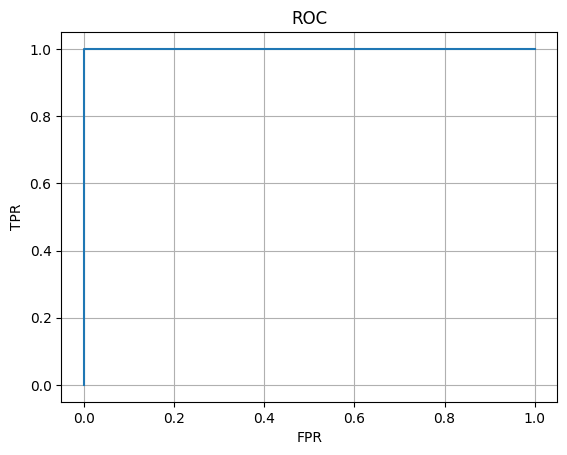

Chosen θ = 0.65


In [ ]:

from glob import glob
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def cosine(u, v): return float(torch.dot(u, v))

y_true, y_score = [], []
for fn in glob("val_pos/*.jpg") + glob("val_neg/*.jpg"):
    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    face = mtcnn(img);  vec = embed(face.unsqueeze(0).to(device))[0]
    vec = vec / vec.norm()
    score = max(cosine(vec, e) for e in ref_db.values())
    y_score.append(score)
    y_true.append(int("val_pos" in fn))

fpr, tpr, _ = roc_curve(y_true, y_score)
print("AUC =", auc(fpr, tpr))

plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC");
plt.grid(); plt.show()

θ = 0.65  # threshold for cosine similarity
print("Chosen θ =", θ)

In [ ]:

try:
    import RPi.GPIO as GPIO
    ON_PI = True
except (ImportError, RuntimeError):
    ON_PI = False 

def setup_relay(pin=17):
    if ON_PI:
        GPIO.setmode(GPIO.BCM)
        GPIO.setup(pin, GPIO.OUT, initial=GPIO.LOW)
    return pin

def pulse_relay(pin, seconds=2):
    if ON_PI:
        GPIO.output(pin, GPIO.HIGH)
        time.sleep(seconds)
        GPIO.output(pin, GPIO.LOW)
    else:
        print(f"🔓  Door unlocked (simulated) for {seconds}s")



ref_db = np.load("ref_db.npy", allow_pickle=True).item()
ref_db = {k: torch.tensor(v).to(device) for k, v in ref_db.items()}

relay_pin = setup_relay(pin=17)
θ         = 0.65

cap = cv2.VideoCapture(0)
assert cap.isOpened(), "Camera not found"

def identify(frame_bgr):
    face = mtcnn(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
    if face is None: return None, 0.0
    vec  = embed(face.unsqueeze(0).to(device))[0]
    vec  = vec / vec.norm()
    name, score = max(
        ((n, float(torch.dot(vec, e))) for n, e in ref_db.items()),
        key=lambda t: t[1]
    )
    return (name, score) if score > θ else (None, score)

print("▶️ Press ESC to quit")
try:
    while True:
        ok, frame = cap.read();  assert ok
        user, sim = identify(frame)
        if user:
            print(f"✅ {user} @ {time.strftime('%H:%M:%S')}  (sim={sim:.3f})")
            pulse_relay(relay_pin)
        elif user is None and sim > 0.3:
            print(f"❌ Someone similar to an enrolled user detected, but not recognized. Access denied.")
        else:
            print(f"❌ Unknown face detected @ {time.strftime('%H:%M:%S')}  (sim={sim:.3f})")
        cv2.imshow("live", frame)
        if cv2.waitKey(1) & 0xFF == 27: break
finally:
    cap.release(); cv2.destroyAllWindows()
    if ON_PI: GPIO.cleanup()

C:\Users\manub\AppData\Local\Temp\ipykernel_17808\1732093623.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_db = {k: torch.tensor(v).to(device) for k, v in ref_db.items()}


▶️ Press ESC to quit
✅ Owner @ 14:56:04  (sim=0.915)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:04  (sim=0.902)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:04  (sim=0.915)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:04  (sim=0.922)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:04  (sim=0.900)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:04  (sim=0.891)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:05  (sim=0.854)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:05  (sim=0.905)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:05  (sim=0.911)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:05  (sim=0.932)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:06  (sim=0.910)
🔓  Door unlocked (simulated) for 2s
✅ Owner @ 14:56:06  (sim=0.891)
🔓  Door unlocked (simulated) for 2s
❌ Unknown face detected @ 14:56:06  (sim=0.000)
❌ Unknown face detected @ 14:56:06  (sim=0.000)
❌ Unknown face detected @ 14:56:06  (sim=0.000)
❌ Unknown face dete

KeyboardInterrupt: 